In [15]:
import torch
import torchvision
from torch.utils.data import Dataset
import torchvision.transforms.functional as fn
import torchvision.transforms as T
import matplotlib.pyplot as plt
from utilities import createAnnotation
from model_loader import get_new_model
import pandas as pd
from IPython.display import display
from PIL import Image 
import random
import numpy as np
import class_katalog

In [16]:
IMAGESROOTDIR = 'NINCO_OOD_classes'

In [17]:
class ImageDataset(Dataset):
    def __init__(self, rootDir):
        self.rootDir = rootDir
        createAnnotation(self.rootDir)
        self.annotation =  pd.read_csv('output.csv')


    def __getitem__(self, index):
        data_path = self.annotation.iloc[index,0]
        image = Image.open(data_path)
        label = self.annotation.iloc[index,1]
        return image, label

    def __len__(self):
        return len(self.annotation)

In [18]:
# instance of class ImageDataset
# contains all 765 images with their respective labels
imageDataset = ImageDataset(rootDir=IMAGESROOTDIR)

In [19]:
# Constants for the size of the images
SIZE = round(224/0.875)

# given an Index returns the transformed Image
# input: Index: int
# return: tuple(PIL Image, label)
def transform(index):
    assert index <= len(imageDataset)
    image, label = imageDataset[index]
    rescaledImage = fn.resize(img=image, size=[SIZE, SIZE], interpolation=T.InterpolationMode.BICUBIC)
    transformedImage = fn.center_crop(img=rescaledImage, output_size=[SIZE,SIZE])
    return transformedImage,label

In [20]:
# objects for tensor transformation
pilToTensor = T.ToTensor()
tensorToPil = T.ToPILImage()

In [21]:
# Class which is used to get the resized images with label
# input: datasetLength: int
# output:{'image': Tensor, 'label': String}
class DataLoader(Dataset):
    def __init__(self, datasetLength):
        self.datasetLength = datasetLength
   
    def __getitem__(self, index):
        assert (0 < index <= self.datasetLength)
        self.index = index
        (picture, label) = transform(index)
        image = pilToTensor(picture)
        #print(image.shape)
        #print(image)
        sample3dim = {'image' : image, 'label' : label}
        image = image.unsqueeze(0)
        #print(image.shape)
        #print(image)
        sample = {'image': image, 'label': label}
        return sample, sample3dim

In [22]:
# Amount of random samples 
BATCHSIZE = 4

dataloader = DataLoader(len(imageDataset))

'''
function creates a random batch of data with a given size
Arguments: batchsize:int
Return: an array with a dict[image:label] 
'''
def createRandomBatch(batchsize):
    assert (0<batchsize <= len(imageDataset))
    batch = []
    batch3dim = []
    indexList = []
    for i in range(batchsize):
        index = random.randint(0,len(imageDataset))
        indexList.append(index)
        sample, sample3dim = dataloader[index]
        batch.append(sample)
        batch3dim.append(sample3dim)
    return batch, batch3dim, indexList

samples, samples3dim, indexList = createRandomBatch(BATCHSIZE)
  
    
    

In [23]:
# loads pretrained model
model = get_new_model("convnext_tiny", not_original=True)


'''
function feeds the loaded model with data
Arguments: list[dict[image:tensor,label:str]]
Return: list[dict[image:tensor,label:str, prediction:tensor]]
'''
def feedModel(samples):
    assert(0<len(samples)<len(imageDataset))
    samplesWithPrediction =[]
    for sample in samples:
        image, label = sample['image'], sample['label']
        prediction = model(image)
        sample['prediction'] = prediction
        samplesWithPrediction.append(sample)
    return samplesWithPrediction
        
samplesWithPrediction = feedModel(samples)

['donuts', 'lepomis_auritus', 'cirsium_pitcheri', 'araneus_gemma']


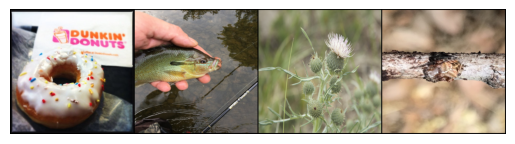

In [24]:
'''
function extracts the values from the samples dict
Arguments: dict which contains random batch dict
Return: returns the values from samples list
'''
def extractValuesFromDict(samples, key:str):
    values = []
    for dictionary in samples:
        values.append(dictionary[key])
        
    if key == 'label':
        print(values)
    return values


# function to visualize the batch
def visualize(samples):
    tensors = extractValuesFromDict(samples, 'image')
    grid_border_size = 2
    elementsPerRow = 4
    grid = torchvision.utils.make_grid(tensor=tensors, nrow=elementsPerRow, padding=grid_border_size)
    plt.imshow(grid.detach().numpy().transpose((1,2,0)))


plt.figure()
visualize(samples3dim)
extractValuesFromDict(samples3dim, 'label')
plt.axis('off')
plt.ioff()
plt.show()

In [25]:
# function that finds the top k predictions
def findMaxPredictions(samples, k:int):
    
    predictionsMax = []
    predictionsIndices = []
    
    for dictionary in samples:
        predictions = dictionary['prediction']
        tempPredictionsMax = []
        tempPredictionsIndices = []
        for i in range (0, k):
            maximums = []
            indices = []
            maximums = predictions.max().item()
            indices = predictions.argmax().item()
            tempPredictionsMax.append(maximums)
            tempPredictionsIndices.append(indices)
            predictions[0][indices] = - float('inf') # set probability of maximum to -inf to search for the next maximum
        predictionsMax.append(tempPredictionsMax)
        predictionsIndices.append(tempPredictionsIndices)
        
    return (predictionsMax, predictionsIndices)


# function that finds the labels to the top k predictions
def findLabels(samples, k:int):
    
    (predictionsMax, predictionsIndices) = findMaxPredictions(samples, k)
    allTopKLabels = []
    
    for i in range (0, BATCHSIZE):
        topKLabels = []
        for j in range (0, k):
            topILabel = []
            topILabel = class_katalog.NAMES[predictionsIndices[i][j]]
            topKLabels.append(topILabel)
        allTopKLabels.append(topKLabels)
        
    return allTopKLabels

findLabels(samples, 10)

[['fire screen, fireguard',
  'window screen',
  'microwave, microwave oven',
  'binder, ring-binder',
  'screen, CRT screen',
  'shower curtain',
  'digital clock',
  'analog clock',
  'spotlight, spot',
  'bubble'],
 ['fire screen, fireguard',
  'window screen',
  'microwave, microwave oven',
  'screen, CRT screen',
  'theater curtain, theatre curtain',
  'binder, ring-binder',
  'analog clock',
  'shower curtain',
  'digital clock',
  'bubble'],
 ['fire screen, fireguard',
  'window screen',
  'analog clock',
  'envelope',
  'theater curtain, theatre curtain',
  'stopwatch, stop watch',
  'digital clock',
  'bubble',
  'screen, CRT screen',
  'syringe'],
 ['fire screen, fireguard',
  'window screen',
  'analog clock',
  'envelope',
  'digital clock',
  'theater curtain, theatre curtain',
  'screen, CRT screen',
  'stopwatch, stop watch',
  'syringe',
  'hourglass']]